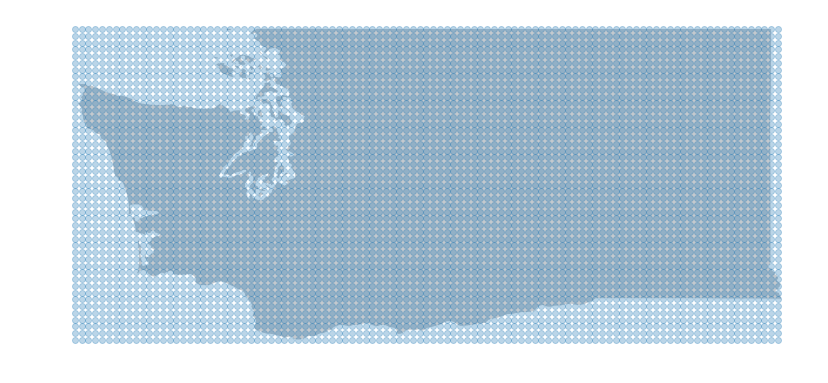

In [3]:
import pandas as pd
import os
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopandas import GeoDataFrame
from shapely.geometry import Polygon
import matplotlib as mpl

%matplotlib inline 
mpl.rcParams['figure.figsize'] = (14,14)

nan = 'np.nan'
bing_api_key = ''
crs = {'init': 'epsg:4326'}

shp = 'Shapes/States/cb_2017_us_state_500k.shp'
us = gpd.read_file(shp)
wa = us[us['STUSPS']=="WA"]
by = .075    #trying a slightly larger grid to keep from crashing everything.


pts_grid = (
    pd.concat([pd.DataFrame({'pts_lon' : np.arange(wa.bounds['minx'], wa.bounds['maxx'], by)})
               , (pd.DataFrame({'pts_lat' : np.arange(wa.bounds['miny'], wa.bounds['maxy'], by)})
                  .pivot(columns = 'pts_lat', values = 'pts_lat'))]
        , axis = 1
             )
    .replace(method='ffill')
    .replace(method='bfill')
    .melt(id_vars=['pts_lon'])
    .drop('variable', 1)
    .rename(columns = {'value' : 'pts_lat'})
    .reset_index()
    .rename(columns={"index": "point_id"})
)
geometry_pts = [Point(xy) for xy in zip(pts_grid.pts_lon, pts_grid.pts_lat)]
gdf_pts_grid = GeoDataFrame(pts_grid, crs=crs, geometry=geometry_pts)

wa_plot = wa.plot(color='#C4C9CE', edgecolor='white')

(    gdf_pts_grid
        .plot(ax=wa_plot, alpha = .3)
        .set_axis_off())



#save to shapefile so I can clip them in QGIS
#gdf_pts_grid.to_file("WA_01grid.shp")
#gdf_pts_grid

In [5]:
from itertools import combinations
from random import randint
import json
from requests.exceptions import HTTPError
from urllib.error import URLError
import simplejson
import urllib
from datetime import datetime
from decimal import Decimal

file = 'Shapes/06/CD06_05pts.shp'
CDgrid = gpd.read_file(file)

#zip lat/long to single column (easier than dealing with shapely geometry)
CDgrid['lat,long'] = list(zip(CDgrid.pts_lat, CDgrid.pts_lon))

#create a list of all coordinates so I can write this to NxN matrix
xytups = CDgrid['lat,long'].tolist()

#find all unique combinations of list entries, removes duplicate geocoding (assuming travel time from A to B = B to A.)
unicombos = [comb for comb in combinations(xytups, 2)]  

#these next lines let me see what I'm up against, computationally - for CD09_05pts, I get 27 points, 351 unique combinations, and 729 possible combinations to work with.
#pointcount = len(xytups)
#totalcombinations = len(xytups)*len(xytups)
#print(pointcount)
#print(len(unicombos)) 
#print(totalcombinations)
   
#create the similarity matrix of n by n points
#dmatrix = pd.DataFrame(index = xytups, columns = xytups)
dmatrix = pd.read_pickle('Shapes/06/CD06_05dmx.pkl')

#now, use the Bing API to populate the matrix. I need to use indexing to extract the data I need since I a tuple within a tuple.
# For example, str(unicombos[0][0][0])) selects the first unique combination, then the first point in the combo, then the first coordinate in that point: ((a,b),(c,d)) becomes 'a'.
length = len(unicombos)
key ='AqNlbBgNl1GeLWrYDrqSZfrvOiXvg5EmLz-8qwGcOsj-ipucZoJQ29O7LJjs-Vka'

print(length)



394716


In [11]:
totalcells = len(xytups)*len(xytups)
print(totalcells)

dcount = dmatrix.describe()

dcount.sum(axis=1)




790321


count     498606.0
unique    485654.0
top            NaN
freq        2182.0
dtype: float64

In [20]:
dmatrix.to_pickle('Shapes/06/CD06_05dmx.pkl')

In [21]:
#need to calculate in sets of 50k per day.
#if failure message, save matrix. Find total count, and begin range at that number.
#save after each failure, but do not run the definition cell again or it will overwrite.
#then run the for loop


#UTC Time = 7 hours ahead of Pacific.


for i in range(350000, 394717):
    #select the target coordinate pairs in each unique tuple (origin, destination)
    origtup = unicombos[i][0]
    desttup = unicombos[i][1]
    
    #select the x and y coordinates for each of the pairs in the unique tuple
    origx = unicombos[i][0][0]
    origy = unicombos[i][0][1]    
    destx = unicombos[i][1][0]
    desty = unicombos[i][1][1]
     
    #cast coordinates to string for the REST API    
    strox = str(origx)
    stroy = str(origy)
    strdx = str(destx)
    strdy = str(desty)
    
    #calculate travel time
    #ttime = randint(1000,9999)
    try:
        url = 'http://dev.virtualearth.net/REST/V1/Routes/Driving?wp.0=' + strox + ',' + stroy + '&wp.1=' + strdx + ',' + strdy + '&key=' + key
        request = urllib.request.Request(url)
        response = urllib.request.urlopen(request)
    except HTTPError:
        ttime = Decimal('nan')
    except URLError:
        ttime = Decimal('nan')
    else:
        r = response.read().decode(encoding="utf-8")
        result = json.loads(r)
        ttime = (result["resourceSets"][0]["resources"][0]["travelDurationTraffic"])
    
    #populate the matrix
    dmatrix.loc[origtup, desttup]= ttime
    dmatrix.loc[desttup, origtup]= ttime
    dmatrix.loc[origtup, origtup]= 0 #setting travel time between identical points to 0, but MDS doesn't like zeros. This is easy to replace, just need to figure out what to replace with.
    print(i)
        
dmatrix.loc[desttup, desttup] = 0 #I added this after, to try and catch the last NaN
dmatrix.to_pickle('Shapes/06/CD06_05dmx.pkl')


350000
350001
350002
350003
350004
350005
350006
350007
350008
350009
350010
350011
350012
350013
350014
350015
350016
350017
350018
350019
350020
350021
350022
350023
350024
350025
350026
350027
350028
350029
350030
350031
350032
350033
350034
350035
350036
350037
350038
350039
350040
350041
350042
350043
350044
350045
350046
350047
350048
350049
350050
350051
350052
350053
350054
350055
350056
350057
350058
350059
350060
350061
350062
350063
350064
350065
350066
350067
350068
350069
350070
350071
350072
350073
350074
350075
350076
350077
350078
350079
350080
350081
350082
350083
350084
350085
350086
350087
350088
350089
350090
350091
350092
350093
350094
350095
350096
350097
350098
350099
350100
350101
350102
350103
350104
350105
350106
350107
350108
350109
350110
350111
350112
350113
350114
350115
350116
350117
350118
350119
350120
350121
350122
350123
350124
350125
350126
350127
350128
350129
350130
350131
350132
350133
350134
350135
350136
350137
350138
350139
350140
350141
350142

351171
351172
351173
351174
351175
351176
351177
351178
351179
351180
351181
351182
351183
351184
351185
351186
351187
351188
351189
351190
351191
351192
351193
351194
351195
351196
351197
351198
351199
351200
351201
351202
351203
351204
351205
351206
351207
351208
351209
351210
351211
351212
351213
351214
351215
351216
351217
351218
351219
351220
351221
351222
351223
351224
351225
351226
351227
351228
351229
351230
351231
351232
351233
351234
351235
351236
351237
351238
351239
351240
351241
351242
351243
351244
351245
351246
351247
351248
351249
351250
351251
351252
351253
351254
351255
351256
351257
351258
351259
351260
351261
351262
351263
351264
351265
351266
351267
351268
351269
351270
351271
351272
351273
351274
351275
351276
351277
351278
351279
351280
351281
351282
351283
351284
351285
351286
351287
351288
351289
351290
351291
351292
351293
351294
351295
351296
351297
351298
351299
351300
351301
351302
351303
351304
351305
351306
351307
351308
351309
351310
351311
351312
351313

352342
352343
352344
352345
352346
352347
352348
352349
352350
352351
352352
352353
352354
352355
352356
352357
352358
352359
352360
352361
352362
352363
352364
352365
352366
352367
352368
352369
352370
352371
352372
352373
352374
352375
352376
352377
352378
352379
352380
352381
352382
352383
352384
352385
352386
352387
352388
352389
352390
352391
352392
352393
352394
352395
352396
352397
352398
352399
352400
352401
352402
352403
352404
352405
352406
352407
352408
352409
352410
352411
352412
352413
352414
352415
352416
352417
352418
352419
352420
352421
352422
352423
352424
352425
352426
352427
352428
352429
352430
352431
352432
352433
352434
352435
352436
352437
352438
352439
352440
352441
352442
352443
352444
352445
352446
352447
352448
352449
352450
352451
352452
352453
352454
352455
352456
352457
352458
352459
352460
352461
352462
352463
352464
352465
352466
352467
352468
352469
352470
352471
352472
352473
352474
352475
352476
352477
352478
352479
352480
352481
352482
352483
352484

353513
353514
353515
353516
353517
353518
353519
353520
353521
353522
353523
353524
353525
353526
353527
353528
353529
353530
353531
353532
353533
353534
353535
353536
353537
353538
353539
353540
353541
353542
353543
353544
353545
353546
353547
353548
353549
353550
353551
353552
353553
353554
353555
353556
353557
353558
353559
353560
353561
353562
353563
353564
353565
353566
353567
353568
353569
353570
353571
353572
353573
353574
353575
353576
353577
353578
353579
353580
353581
353582
353583
353584
353585
353586
353587
353588
353589
353590
353591
353592
353593
353594
353595
353596
353597
353598
353599
353600
353601
353602
353603
353604
353605
353606
353607
353608
353609
353610
353611
353612
353613
353614
353615
353616
353617
353618
353619
353620
353621
353622
353623
353624
353625
353626
353627
353628
353629
353630
353631
353632
353633
353634
353635
353636
353637
353638
353639
353640
353641
353642
353643
353644
353645
353646
353647
353648
353649
353650
353651
353652
353653
353654
353655

354684
354685
354686
354687
354688
354689
354690
354691
354692
354693
354694
354695
354696
354697
354698
354699
354700
354701
354702
354703
354704
354705
354706
354707
354708
354709
354710
354711
354712
354713
354714
354715
354716
354717
354718
354719
354720
354721
354722
354723
354724
354725
354726
354727
354728
354729
354730
354731
354732
354733
354734
354735
354736
354737
354738
354739
354740
354741
354742
354743
354744
354745
354746
354747
354748
354749
354750
354751
354752
354753
354754
354755
354756
354757
354758
354759
354760
354761
354762
354763
354764
354765
354766
354767
354768
354769
354770
354771
354772
354773
354774
354775
354776
354777
354778
354779
354780
354781
354782
354783
354784
354785
354786
354787
354788
354789
354790
354791
354792
354793
354794
354795
354796
354797
354798
354799
354800
354801
354802
354803
354804
354805
354806
354807
354808
354809
354810
354811
354812
354813
354814
354815
354816
354817
354818
354819
354820
354821
354822
354823
354824
354825
354826

355855
355856
355857
355858
355859
355860
355861
355862
355863
355864
355865
355866
355867
355868
355869
355870
355871
355872
355873
355874
355875
355876
355877
355878
355879
355880
355881
355882
355883
355884
355885
355886
355887
355888
355889
355890
355891
355892
355893
355894
355895
355896
355897
355898
355899
355900
355901
355902
355903
355904
355905
355906
355907
355908
355909
355910
355911
355912
355913
355914
355915
355916
355917
355918
355919
355920
355921
355922
355923
355924
355925
355926
355927
355928
355929
355930
355931
355932
355933
355934
355935
355936
355937
355938
355939
355940
355941
355942
355943
355944
355945
355946
355947
355948
355949
355950
355951
355952
355953
355954
355955
355956
355957
355958
355959
355960
355961
355962
355963
355964
355965
355966
355967
355968
355969
355970
355971
355972
355973
355974
355975
355976
355977
355978
355979
355980
355981
355982
355983
355984
355985
355986
355987
355988
355989
355990
355991
355992
355993
355994
355995
355996
355997

357026
357027
357028
357029
357030
357031
357032
357033
357034
357035
357036
357037
357038
357039
357040
357041
357042
357043
357044
357045
357046
357047
357048
357049
357050
357051
357052
357053
357054
357055
357056
357057
357058
357059
357060
357061
357062
357063
357064
357065
357066
357067
357068
357069
357070
357071
357072
357073
357074
357075
357076
357077
357078
357079
357080
357081
357082
357083
357084
357085
357086
357087
357088
357089
357090
357091
357092
357093
357094
357095
357096
357097
357098
357099
357100
357101
357102
357103
357104
357105
357106
357107
357108
357109
357110
357111
357112
357113
357114
357115
357116
357117
357118
357119
357120
357121
357122
357123
357124
357125
357126
357127
357128
357129
357130
357131
357132
357133
357134
357135
357136
357137
357138
357139
357140
357141
357142
357143
357144
357145
357146
357147
357148
357149
357150
357151
357152
357153
357154
357155
357156
357157
357158
357159
357160
357161
357162
357163
357164
357165
357166
357167
357168

358197
358198
358199
358200
358201
358202
358203
358204
358205
358206
358207
358208
358209
358210
358211
358212
358213
358214
358215
358216
358217
358218
358219
358220
358221
358222
358223
358224
358225
358226
358227
358228
358229
358230
358231
358232
358233
358234
358235
358236
358237
358238
358239
358240
358241
358242
358243
358244
358245
358246
358247
358248
358249
358250
358251
358252
358253
358254
358255
358256
358257
358258
358259
358260
358261
358262
358263
358264
358265
358266
358267
358268
358269
358270
358271
358272
358273
358274
358275
358276
358277
358278
358279
358280
358281
358282
358283
358284
358285
358286
358287
358288
358289
358290
358291
358292
358293
358294
358295
358296
358297
358298
358299
358300
358301
358302
358303
358304
358305
358306
358307
358308
358309
358310
358311
358312
358313
358314
358315
358316
358317
358318
358319
358320
358321
358322
358323
358324
358325
358326
358327
358328
358329
358330
358331
358332
358333
358334
358335
358336
358337
358338
358339

359368
359369
359370
359371
359372
359373
359374
359375
359376
359377
359378
359379
359380
359381
359382
359383
359384
359385
359386
359387
359388
359389
359390
359391
359392
359393
359394
359395
359396
359397
359398
359399
359400
359401
359402
359403
359404
359405
359406
359407
359408
359409
359410
359411
359412
359413
359414
359415
359416
359417
359418
359419
359420
359421
359422
359423
359424
359425
359426
359427
359428
359429
359430
359431
359432
359433
359434
359435
359436
359437
359438
359439
359440
359441
359442
359443
359444
359445
359446
359447
359448
359449
359450
359451
359452
359453
359454
359455
359456
359457
359458
359459
359460
359461
359462
359463
359464
359465
359466
359467
359468
359469
359470
359471
359472
359473
359474
359475
359476
359477
359478
359479
359480
359481
359482
359483
359484
359485
359486
359487
359488
359489
359490
359491
359492
359493
359494
359495
359496
359497
359498
359499
359500
359501
359502
359503
359504
359505
359506
359507
359508
359509
359510

360539
360540
360541
360542
360543
360544
360545
360546
360547
360548
360549
360550
360551
360552
360553
360554
360555
360556
360557
360558
360559
360560
360561
360562
360563
360564
360565
360566
360567
360568
360569
360570
360571
360572
360573
360574
360575
360576
360577
360578
360579
360580
360581
360582
360583
360584
360585
360586
360587
360588
360589
360590
360591
360592
360593
360594
360595
360596
360597
360598
360599
360600
360601
360602
360603
360604
360605
360606
360607
360608
360609
360610
360611
360612
360613
360614
360615
360616
360617
360618
360619
360620
360621
360622
360623
360624
360625
360626
360627
360628
360629
360630
360631
360632
360633
360634
360635
360636
360637
360638
360639
360640
360641
360642
360643
360644
360645
360646
360647
360648
360649
360650
360651
360652
360653
360654
360655
360656
360657
360658
360659
360660
360661
360662
360663
360664
360665
360666
360667
360668
360669
360670
360671
360672
360673
360674
360675
360676
360677
360678
360679
360680
360681

361710
361711
361712
361713
361714
361715
361716
361717
361718
361719
361720
361721
361722
361723
361724
361725
361726
361727
361728
361729
361730
361731
361732
361733
361734
361735
361736
361737
361738
361739
361740
361741
361742
361743
361744
361745
361746
361747
361748
361749
361750
361751
361752
361753
361754
361755
361756
361757
361758
361759
361760
361761
361762
361763
361764
361765
361766
361767
361768
361769
361770
361771
361772
361773
361774
361775
361776
361777
361778
361779
361780
361781
361782
361783
361784
361785
361786
361787
361788
361789
361790
361791
361792
361793
361794
361795
361796
361797
361798
361799
361800
361801
361802
361803
361804
361805
361806
361807
361808
361809
361810
361811
361812
361813
361814
361815
361816
361817
361818
361819
361820
361821
361822
361823
361824
361825
361826
361827
361828
361829
361830
361831
361832
361833
361834
361835
361836
361837
361838
361839
361840
361841
361842
361843
361844
361845
361846
361847
361848
361849
361850
361851
361852

362881
362882
362883
362884
362885
362886
362887
362888
362889
362890
362891
362892
362893
362894
362895
362896
362897
362898
362899
362900
362901
362902
362903
362904
362905
362906
362907
362908
362909
362910
362911
362912
362913
362914
362915
362916
362917
362918
362919
362920
362921
362922
362923
362924
362925
362926
362927
362928
362929
362930
362931
362932
362933
362934
362935
362936
362937
362938
362939
362940
362941
362942
362943
362944
362945
362946
362947
362948
362949
362950
362951
362952
362953
362954
362955
362956
362957
362958
362959
362960
362961
362962
362963
362964
362965
362966
362967
362968
362969
362970
362971
362972
362973
362974
362975
362976
362977
362978
362979
362980
362981
362982
362983
362984
362985
362986
362987
362988
362989
362990
362991
362992
362993
362994
362995
362996
362997
362998
362999
363000
363001
363002
363003
363004
363005
363006
363007
363008
363009
363010
363011
363012
363013
363014
363015
363016
363017
363018
363019
363020
363021
363022
363023

364052
364053
364054
364055
364056
364057
364058
364059
364060
364061
364062
364063
364064
364065
364066
364067
364068
364069
364070
364071
364072
364073
364074
364075
364076
364077
364078
364079
364080
364081
364082
364083
364084
364085
364086
364087
364088
364089
364090
364091
364092
364093
364094
364095
364096
364097
364098
364099
364100
364101
364102
364103
364104
364105
364106
364107
364108
364109
364110
364111
364112
364113
364114
364115
364116
364117
364118
364119
364120
364121
364122
364123
364124
364125
364126
364127
364128
364129
364130
364131
364132
364133
364134
364135
364136
364137
364138
364139
364140
364141
364142
364143
364144
364145
364146
364147
364148
364149
364150
364151
364152
364153
364154
364155
364156
364157
364158
364159
364160
364161
364162
364163
364164
364165
364166
364167
364168
364169
364170
364171
364172
364173
364174
364175
364176
364177
364178
364179
364180
364181
364182
364183
364184
364185
364186
364187
364188
364189
364190
364191
364192
364193
364194

365223
365224
365225
365226
365227
365228
365229
365230
365231
365232
365233
365234
365235
365236
365237
365238
365239
365240
365241
365242
365243
365244
365245
365246
365247
365248
365249
365250
365251
365252
365253
365254
365255
365256
365257
365258
365259
365260
365261
365262
365263
365264
365265
365266
365267
365268
365269
365270
365271
365272
365273
365274
365275
365276
365277
365278
365279
365280
365281
365282
365283
365284
365285
365286
365287
365288
365289
365290
365291
365292
365293
365294
365295
365296
365297
365298
365299
365300
365301
365302
365303
365304
365305
365306
365307
365308
365309
365310
365311
365312
365313
365314
365315
365316
365317
365318
365319
365320
365321
365322
365323
365324
365325
365326
365327
365328
365329
365330
365331
365332
365333
365334
365335
365336
365337
365338
365339
365340
365341
365342
365343
365344
365345
365346
365347
365348
365349
365350
365351
365352
365353
365354
365355
365356
365357
365358
365359
365360
365361
365362
365363
365364
365365

366394
366395
366396
366397
366398
366399
366400
366401
366402
366403
366404
366405
366406
366407
366408
366409
366410
366411
366412
366413
366414
366415
366416
366417
366418
366419
366420
366421
366422
366423
366424
366425
366426
366427
366428
366429
366430
366431
366432
366433
366434
366435
366436
366437
366438
366439
366440
366441
366442
366443
366444
366445
366446
366447
366448
366449
366450
366451
366452
366453
366454
366455
366456
366457
366458
366459
366460
366461
366462
366463
366464
366465
366466
366467
366468
366469
366470
366471
366472
366473
366474
366475
366476
366477
366478
366479
366480
366481
366482
366483
366484
366485
366486
366487
366488
366489
366490
366491
366492
366493
366494
366495
366496
366497
366498
366499
366500
366501
366502
366503
366504
366505
366506
366507
366508
366509
366510
366511
366512
366513
366514
366515
366516
366517
366518
366519
366520
366521
366522
366523
366524
366525
366526
366527
366528
366529
366530
366531
366532
366533
366534
366535
366536

367565
367566
367567
367568
367569
367570
367571
367572
367573
367574
367575
367576
367577
367578
367579
367580
367581
367582
367583
367584
367585
367586
367587
367588
367589
367590
367591
367592
367593
367594
367595
367596
367597
367598
367599
367600
367601
367602
367603
367604
367605
367606
367607
367608
367609
367610
367611
367612
367613
367614
367615
367616
367617
367618
367619
367620
367621
367622
367623
367624
367625
367626
367627
367628
367629
367630
367631
367632
367633
367634
367635
367636
367637
367638
367639
367640
367641
367642
367643
367644
367645
367646
367647
367648
367649
367650
367651
367652
367653
367654
367655
367656
367657
367658
367659
367660
367661
367662
367663
367664
367665
367666
367667
367668
367669
367670
367671
367672
367673
367674
367675
367676
367677
367678
367679
367680
367681
367682
367683
367684
367685
367686
367687
367688
367689
367690
367691
367692
367693
367694
367695
367696
367697
367698
367699
367700
367701
367702
367703
367704
367705
367706
367707

368736
368737
368738
368739
368740
368741
368742
368743
368744
368745
368746
368747
368748
368749
368750
368751
368752
368753
368754
368755
368756
368757
368758
368759
368760
368761
368762
368763
368764
368765
368766
368767
368768
368769
368770
368771
368772
368773
368774
368775
368776
368777
368778
368779
368780
368781
368782
368783
368784
368785
368786
368787
368788
368789
368790
368791
368792
368793
368794
368795
368796
368797
368798
368799
368800
368801
368802
368803
368804
368805
368806
368807
368808
368809
368810
368811
368812
368813
368814
368815
368816
368817
368818
368819
368820
368821
368822
368823
368824
368825
368826
368827
368828
368829
368830
368831
368832
368833
368834
368835
368836
368837
368838
368839
368840
368841
368842
368843
368844
368845
368846
368847
368848
368849
368850
368851
368852
368853
368854
368855
368856
368857
368858
368859
368860
368861
368862
368863
368864
368865
368866
368867
368868
368869
368870
368871
368872
368873
368874
368875
368876
368877
368878

369907
369908
369909
369910
369911
369912
369913
369914
369915
369916
369917
369918
369919
369920
369921
369922
369923
369924
369925
369926
369927
369928
369929
369930
369931
369932
369933
369934
369935
369936
369937
369938
369939
369940
369941
369942
369943
369944
369945
369946
369947
369948
369949
369950
369951
369952
369953
369954
369955
369956
369957
369958
369959
369960
369961
369962
369963
369964
369965
369966
369967
369968
369969
369970
369971
369972
369973
369974
369975
369976
369977
369978
369979
369980
369981
369982
369983
369984
369985
369986
369987
369988
369989
369990
369991
369992
369993
369994
369995
369996
369997
369998
369999
370000
370001
370002
370003
370004
370005
370006
370007
370008
370009
370010
370011
370012
370013
370014
370015
370016
370017
370018
370019
370020
370021
370022
370023
370024
370025
370026
370027
370028
370029
370030
370031
370032
370033
370034
370035
370036
370037
370038
370039
370040
370041
370042
370043
370044
370045
370046
370047
370048
370049

371078
371079
371080
371081
371082
371083
371084
371085
371086
371087
371088
371089
371090
371091
371092
371093
371094
371095
371096
371097
371098
371099
371100
371101
371102
371103
371104
371105
371106
371107
371108
371109
371110
371111
371112
371113
371114
371115
371116
371117
371118
371119
371120
371121
371122
371123
371124
371125
371126
371127
371128
371129
371130
371131
371132
371133
371134
371135
371136
371137
371138
371139
371140
371141
371142
371143
371144
371145
371146
371147
371148
371149
371150
371151
371152
371153
371154
371155
371156
371157
371158
371159
371160
371161
371162
371163
371164
371165
371166
371167
371168
371169
371170
371171
371172
371173
371174
371175
371176
371177
371178
371179
371180
371181
371182
371183
371184
371185
371186
371187
371188
371189
371190
371191
371192
371193
371194
371195
371196
371197
371198
371199
371200
371201
371202
371203
371204
371205
371206
371207
371208
371209
371210
371211
371212
371213
371214
371215
371216
371217
371218
371219
371220

372249
372250
372251
372252
372253
372254
372255
372256
372257
372258
372259
372260
372261
372262
372263
372264
372265
372266
372267
372268
372269
372270
372271
372272
372273
372274
372275
372276
372277
372278
372279
372280
372281
372282
372283
372284
372285
372286
372287
372288
372289
372290
372291
372292
372293
372294
372295
372296
372297
372298
372299
372300
372301
372302
372303
372304
372305
372306
372307
372308
372309
372310
372311
372312
372313
372314
372315
372316
372317
372318
372319
372320
372321
372322
372323
372324
372325
372326
372327
372328
372329
372330
372331
372332
372333
372334
372335
372336
372337
372338
372339
372340
372341
372342
372343
372344
372345
372346
372347
372348
372349
372350
372351
372352
372353
372354
372355
372356
372357
372358
372359
372360
372361
372362
372363
372364
372365
372366
372367
372368
372369
372370
372371
372372
372373
372374
372375
372376
372377
372378
372379
372380
372381
372382
372383
372384
372385
372386
372387
372388
372389
372390
372391

373420
373421
373422
373423
373424
373425
373426
373427
373428
373429
373430
373431
373432
373433
373434
373435
373436
373437
373438
373439
373440
373441
373442
373443
373444
373445
373446
373447
373448
373449
373450
373451
373452
373453
373454
373455
373456
373457
373458
373459
373460
373461
373462
373463
373464
373465
373466
373467
373468
373469
373470
373471
373472
373473
373474
373475
373476
373477
373478
373479
373480
373481
373482
373483
373484
373485
373486
373487
373488
373489
373490
373491
373492
373493
373494
373495
373496
373497
373498
373499
373500
373501
373502
373503
373504
373505
373506
373507
373508
373509
373510
373511
373512
373513
373514
373515
373516
373517
373518
373519
373520
373521
373522
373523
373524
373525
373526
373527
373528
373529
373530
373531
373532
373533
373534
373535
373536
373537
373538
373539
373540
373541
373542
373543
373544
373545
373546
373547
373548
373549
373550
373551
373552
373553
373554
373555
373556
373557
373558
373559
373560
373561
373562

374591
374592
374593
374594
374595
374596
374597
374598
374599
374600
374601
374602
374603
374604
374605
374606
374607
374608
374609
374610
374611
374612
374613
374614
374615
374616
374617
374618
374619
374620
374621
374622
374623
374624
374625
374626
374627
374628
374629
374630
374631
374632
374633
374634
374635
374636
374637
374638
374639
374640
374641
374642
374643
374644
374645
374646
374647
374648
374649
374650
374651
374652
374653
374654
374655
374656
374657
374658
374659
374660
374661
374662
374663
374664
374665
374666
374667
374668
374669
374670
374671
374672
374673
374674
374675
374676
374677
374678
374679
374680
374681
374682
374683
374684
374685
374686
374687
374688
374689
374690
374691
374692
374693
374694
374695
374696
374697
374698
374699
374700
374701
374702
374703
374704
374705
374706
374707
374708
374709
374710
374711
374712
374713
374714
374715
374716
374717
374718
374719
374720
374721
374722
374723
374724
374725
374726
374727
374728
374729
374730
374731
374732
374733

375762
375763
375764
375765
375766
375767
375768
375769
375770
375771
375772
375773
375774
375775
375776
375777
375778
375779
375780
375781
375782
375783
375784
375785
375786
375787
375788
375789
375790
375791
375792
375793
375794
375795
375796
375797
375798
375799
375800
375801
375802
375803
375804
375805
375806
375807
375808
375809
375810
375811
375812
375813
375814
375815
375816
375817
375818
375819
375820
375821
375822
375823
375824
375825
375826
375827
375828
375829
375830
375831
375832
375833
375834
375835
375836
375837
375838
375839
375840
375841
375842
375843
375844
375845
375846
375847
375848
375849
375850
375851
375852
375853
375854
375855
375856
375857
375858
375859
375860
375861
375862
375863
375864
375865
375866
375867
375868
375869
375870
375871
375872
375873
375874
375875
375876
375877
375878
375879
375880
375881
375882
375883
375884
375885
375886
375887
375888
375889
375890
375891
375892
375893
375894
375895
375896
375897
375898
375899
375900
375901
375902
375903
375904

376933
376934
376935
376936
376937
376938
376939
376940
376941
376942
376943
376944
376945
376946
376947
376948
376949
376950
376951
376952
376953
376954
376955
376956
376957
376958
376959
376960
376961
376962
376963
376964
376965
376966
376967
376968
376969
376970
376971
376972
376973
376974
376975
376976
376977
376978
376979
376980
376981
376982
376983
376984
376985
376986
376987
376988
376989
376990
376991
376992
376993
376994
376995
376996
376997
376998
376999
377000
377001
377002
377003
377004
377005
377006
377007
377008
377009
377010
377011
377012
377013
377014
377015
377016
377017
377018
377019
377020
377021
377022
377023
377024
377025
377026
377027
377028
377029
377030
377031
377032
377033
377034
377035
377036
377037
377038
377039
377040
377041
377042
377043
377044
377045
377046
377047
377048
377049
377050
377051
377052
377053
377054
377055
377056
377057
377058
377059
377060
377061
377062
377063
377064
377065
377066
377067
377068
377069
377070
377071
377072
377073
377074
377075

378104
378105
378106
378107
378108
378109
378110
378111
378112
378113
378114
378115
378116
378117
378118
378119
378120
378121
378122
378123
378124
378125
378126
378127
378128
378129
378130
378131
378132
378133
378134
378135
378136
378137
378138
378139
378140
378141
378142
378143
378144
378145
378146
378147
378148
378149
378150
378151
378152
378153
378154
378155
378156
378157
378158
378159
378160
378161
378162
378163
378164
378165
378166
378167
378168
378169
378170
378171
378172
378173
378174
378175
378176
378177
378178
378179
378180
378181
378182
378183
378184
378185
378186
378187
378188
378189
378190
378191
378192
378193
378194
378195
378196
378197
378198
378199
378200
378201
378202
378203
378204
378205
378206
378207
378208
378209
378210
378211
378212
378213
378214
378215
378216
378217
378218
378219
378220
378221
378222
378223
378224
378225
378226
378227
378228
378229
378230
378231
378232
378233
378234
378235
378236
378237
378238
378239
378240
378241
378242
378243
378244
378245
378246

379275
379276
379277
379278
379279
379280
379281
379282
379283
379284
379285
379286
379287
379288
379289
379290
379291
379292
379293
379294
379295
379296
379297
379298
379299
379300
379301
379302
379303
379304
379305
379306
379307
379308
379309
379310
379311
379312
379313
379314
379315
379316
379317
379318
379319
379320
379321
379322
379323
379324
379325
379326
379327
379328
379329
379330
379331
379332
379333
379334
379335
379336
379337
379338
379339
379340
379341
379342
379343
379344
379345
379346
379347
379348
379349
379350
379351
379352
379353
379354
379355
379356
379357
379358
379359
379360
379361
379362
379363
379364
379365
379366
379367
379368
379369
379370
379371
379372
379373
379374
379375
379376
379377
379378
379379
379380
379381
379382
379383
379384
379385
379386
379387
379388
379389
379390
379391
379392
379393
379394
379395
379396
379397
379398
379399
379400
379401
379402
379403
379404
379405
379406
379407
379408
379409
379410
379411
379412
379413
379414
379415
379416
379417

380446
380447
380448
380449
380450
380451
380452
380453
380454
380455
380456
380457
380458
380459
380460
380461
380462
380463
380464
380465
380466
380467
380468
380469
380470
380471
380472
380473
380474
380475
380476
380477
380478
380479
380480
380481
380482
380483
380484
380485
380486
380487
380488
380489
380490
380491
380492
380493
380494
380495
380496
380497
380498
380499
380500
380501
380502
380503
380504
380505
380506
380507
380508
380509
380510
380511
380512
380513
380514
380515
380516
380517
380518
380519
380520
380521
380522
380523
380524
380525
380526
380527
380528
380529
380530
380531
380532
380533
380534
380535
380536
380537
380538
380539
380540
380541
380542
380543
380544
380545
380546
380547
380548
380549
380550
380551
380552
380553
380554
380555
380556
380557
380558
380559
380560
380561
380562
380563
380564
380565
380566
380567
380568
380569
380570
380571
380572
380573
380574
380575
380576
380577
380578
380579
380580
380581
380582
380583
380584
380585
380586
380587
380588

381617
381618
381619
381620
381621
381622
381623
381624
381625
381626
381627
381628
381629
381630
381631
381632
381633
381634
381635
381636
381637
381638
381639
381640
381641
381642
381643
381644
381645
381646
381647
381648
381649
381650
381651
381652
381653
381654
381655
381656
381657
381658
381659
381660
381661
381662
381663
381664
381665
381666
381667
381668
381669
381670
381671
381672
381673
381674
381675
381676
381677
381678
381679
381680
381681
381682
381683
381684
381685
381686
381687
381688
381689
381690
381691
381692
381693
381694
381695
381696
381697
381698
381699
381700
381701
381702
381703
381704
381705
381706
381707
381708
381709
381710
381711
381712
381713
381714
381715
381716
381717
381718
381719
381720
381721
381722
381723
381724
381725
381726
381727
381728
381729
381730
381731
381732
381733
381734
381735
381736
381737
381738
381739
381740
381741
381742
381743
381744
381745
381746
381747
381748
381749
381750
381751
381752
381753
381754
381755
381756
381757
381758
381759

382788
382789
382790
382791
382792
382793
382794
382795
382796
382797
382798
382799
382800
382801
382802
382803
382804
382805
382806
382807
382808
382809
382810
382811
382812
382813
382814
382815
382816
382817
382818
382819
382820
382821
382822
382823
382824
382825
382826
382827
382828
382829
382830
382831
382832
382833
382834
382835
382836
382837
382838
382839
382840
382841
382842
382843
382844
382845
382846
382847
382848
382849
382850
382851
382852
382853
382854
382855
382856
382857
382858
382859
382860
382861
382862
382863
382864
382865
382866
382867
382868
382869
382870
382871
382872
382873
382874
382875
382876
382877
382878
382879
382880
382881
382882
382883
382884
382885
382886
382887
382888
382889
382890
382891
382892
382893
382894
382895
382896
382897
382898
382899
382900
382901
382902
382903
382904
382905
382906
382907
382908
382909
382910
382911
382912
382913
382914
382915
382916
382917
382918
382919
382920
382921
382922
382923
382924
382925
382926
382927
382928
382929
382930

383959
383960
383961
383962
383963
383964
383965
383966
383967
383968
383969
383970
383971
383972
383973
383974
383975
383976
383977
383978
383979
383980
383981
383982
383983
383984
383985
383986
383987
383988
383989
383990
383991
383992
383993
383994
383995
383996
383997
383998
383999
384000
384001
384002
384003
384004
384005
384006
384007
384008
384009
384010
384011
384012
384013
384014
384015
384016
384017
384018
384019
384020
384021
384022
384023
384024
384025
384026
384027
384028
384029
384030
384031
384032
384033
384034
384035
384036
384037
384038
384039
384040
384041
384042
384043
384044
384045
384046
384047
384048
384049
384050
384051
384052
384053
384054
384055
384056
384057
384058
384059
384060
384061
384062
384063
384064
384065
384066
384067
384068
384069
384070
384071
384072
384073
384074
384075
384076
384077
384078
384079
384080
384081
384082
384083
384084
384085
384086
384087
384088
384089
384090
384091
384092
384093
384094
384095
384096
384097
384098
384099
384100
384101

385130
385131
385132
385133
385134
385135
385136
385137
385138
385139
385140
385141
385142
385143
385144
385145
385146
385147
385148
385149
385150
385151
385152
385153
385154
385155
385156
385157
385158
385159
385160
385161
385162
385163
385164
385165
385166
385167
385168
385169
385170
385171
385172
385173
385174
385175
385176
385177
385178
385179
385180
385181
385182
385183
385184
385185
385186
385187
385188
385189
385190
385191
385192
385193
385194
385195
385196
385197
385198
385199
385200
385201
385202
385203
385204
385205
385206
385207
385208
385209
385210
385211
385212
385213
385214
385215
385216
385217
385218
385219
385220
385221
385222
385223
385224
385225
385226
385227
385228
385229
385230
385231
385232
385233
385234
385235
385236
385237
385238
385239
385240
385241
385242
385243
385244
385245
385246
385247
385248
385249
385250
385251
385252
385253
385254
385255
385256
385257
385258
385259
385260
385261
385262
385263
385264
385265
385266
385267
385268
385269
385270
385271
385272

386301
386302
386303
386304
386305
386306
386307
386308
386309
386310
386311
386312
386313
386314
386315
386316
386317
386318
386319
386320
386321
386322
386323
386324
386325
386326
386327
386328
386329
386330
386331
386332
386333
386334
386335
386336
386337
386338
386339
386340
386341
386342
386343
386344
386345
386346
386347
386348
386349
386350
386351
386352
386353
386354
386355
386356
386357
386358
386359
386360
386361
386362
386363
386364
386365
386366
386367
386368
386369
386370
386371
386372
386373
386374
386375
386376
386377
386378
386379
386380
386381
386382
386383
386384
386385
386386
386387
386388
386389
386390
386391
386392
386393
386394
386395
386396
386397
386398
386399
386400
386401
386402
386403
386404
386405
386406
386407
386408
386409
386410
386411
386412
386413
386414
386415
386416
386417
386418
386419
386420
386421
386422
386423
386424
386425
386426
386427
386428
386429
386430
386431
386432
386433
386434
386435
386436
386437
386438
386439
386440
386441
386442
386443

387472
387473
387474
387475
387476
387477
387478
387479
387480
387481
387482
387483
387484
387485
387486
387487
387488
387489
387490
387491
387492
387493
387494
387495
387496
387497
387498
387499
387500
387501
387502
387503
387504
387505
387506
387507
387508
387509
387510
387511
387512
387513
387514
387515
387516
387517
387518
387519
387520
387521
387522
387523
387524
387525
387526
387527
387528
387529
387530
387531
387532
387533
387534
387535
387536
387537
387538
387539
387540
387541
387542
387543
387544
387545
387546
387547
387548
387549
387550
387551
387552
387553
387554
387555
387556
387557
387558
387559
387560
387561
387562
387563
387564
387565
387566
387567
387568
387569
387570
387571
387572
387573
387574
387575
387576
387577
387578
387579
387580
387581
387582
387583
387584
387585
387586
387587
387588
387589
387590
387591
387592
387593
387594
387595
387596
387597
387598
387599
387600
387601
387602
387603
387604
387605
387606
387607
387608
387609
387610
387611
387612
387613
387614

388643
388644
388645
388646
388647
388648
388649
388650
388651
388652
388653
388654
388655
388656
388657
388658
388659
388660
388661
388662
388663
388664
388665
388666
388667
388668
388669
388670
388671
388672
388673
388674
388675
388676
388677
388678
388679
388680
388681
388682
388683
388684
388685
388686
388687
388688
388689
388690
388691
388692
388693
388694
388695
388696
388697
388698
388699
388700
388701
388702
388703
388704
388705
388706
388707
388708
388709
388710
388711
388712
388713
388714
388715
388716
388717
388718
388719
388720
388721
388722
388723
388724
388725
388726
388727
388728
388729
388730
388731
388732
388733
388734
388735
388736
388737
388738
388739
388740
388741
388742
388743
388744
388745
388746
388747
388748
388749
388750
388751
388752
388753
388754
388755
388756
388757
388758
388759
388760
388761
388762
388763
388764
388765
388766
388767
388768
388769
388770
388771
388772
388773
388774
388775
388776
388777
388778
388779
388780
388781
388782
388783
388784
388785

389814
389815
389816
389817
389818
389819
389820
389821
389822
389823
389824
389825
389826
389827
389828
389829
389830
389831
389832
389833
389834
389835
389836
389837
389838
389839
389840
389841
389842
389843
389844
389845
389846
389847
389848
389849
389850
389851
389852
389853
389854
389855
389856
389857
389858
389859
389860
389861
389862
389863
389864
389865
389866
389867
389868
389869
389870
389871
389872
389873
389874
389875
389876
389877
389878
389879
389880
389881
389882
389883
389884
389885
389886
389887
389888
389889
389890
389891
389892
389893
389894
389895
389896
389897
389898
389899
389900
389901
389902
389903
389904
389905
389906
389907
389908
389909
389910
389911
389912
389913
389914
389915
389916
389917
389918
389919
389920
389921
389922
389923
389924
389925
389926
389927
389928
389929
389930
389931
389932
389933
389934
389935
389936
389937
389938
389939
389940
389941
389942
389943
389944
389945
389946
389947
389948
389949
389950
389951
389952
389953
389954
389955
389956

390985
390986
390987
390988
390989
390990
390991
390992
390993
390994
390995
390996
390997
390998
390999
391000
391001
391002
391003
391004
391005
391006
391007
391008
391009
391010
391011
391012
391013
391014
391015
391016
391017
391018
391019
391020
391021
391022
391023
391024
391025
391026
391027
391028
391029
391030
391031
391032
391033
391034
391035
391036
391037
391038
391039
391040
391041
391042
391043
391044
391045
391046
391047
391048
391049
391050
391051
391052
391053
391054
391055
391056
391057
391058
391059
391060
391061
391062
391063
391064
391065
391066
391067
391068
391069
391070
391071
391072
391073
391074
391075
391076
391077
391078
391079
391080
391081
391082
391083
391084
391085
391086
391087
391088
391089
391090
391091
391092
391093
391094
391095
391096
391097
391098
391099
391100
391101
391102
391103
391104
391105
391106
391107
391108
391109
391110
391111
391112
391113
391114
391115
391116
391117
391118
391119
391120
391121
391122
391123
391124
391125
391126
391127

392156
392157
392158
392159
392160
392161
392162
392163
392164
392165
392166
392167
392168
392169
392170
392171
392172
392173
392174
392175
392176
392177
392178
392179
392180
392181
392182
392183
392184
392185
392186
392187
392188
392189
392190
392191
392192
392193
392194
392195
392196
392197
392198
392199
392200
392201
392202
392203
392204
392205
392206
392207
392208
392209
392210
392211
392212
392213
392214
392215
392216
392217
392218
392219
392220
392221
392222
392223
392224
392225
392226
392227
392228
392229
392230
392231
392232
392233
392234
392235
392236
392237
392238
392239
392240
392241
392242
392243
392244
392245
392246
392247
392248
392249
392250
392251
392252
392253
392254
392255
392256
392257
392258
392259
392260
392261
392262
392263
392264
392265
392266
392267
392268
392269
392270
392271
392272
392273
392274
392275
392276
392277
392278
392279
392280
392281
392282
392283
392284
392285
392286
392287
392288
392289
392290
392291
392292
392293
392294
392295
392296
392297
392298

393327
393328
393329
393330
393331
393332
393333
393334
393335
393336
393337
393338
393339
393340
393341
393342
393343
393344
393345
393346
393347
393348
393349
393350
393351
393352
393353
393354
393355
393356
393357
393358
393359
393360
393361
393362
393363
393364
393365
393366
393367
393368
393369
393370
393371
393372
393373
393374
393375
393376
393377
393378
393379
393380
393381
393382
393383
393384
393385
393386
393387
393388
393389
393390
393391
393392
393393
393394
393395
393396
393397
393398
393399
393400
393401
393402
393403
393404
393405
393406
393407
393408
393409
393410
393411
393412
393413
393414
393415
393416
393417
393418
393419
393420
393421
393422
393423
393424
393425
393426
393427
393428
393429
393430
393431
393432
393433
393434
393435
393436
393437
393438
393439
393440
393441
393442
393443
393444
393445
393446
393447
393448
393449
393450
393451
393452
393453
393454
393455
393456
393457
393458
393459
393460
393461
393462
393463
393464
393465
393466
393467
393468
393469

394498
394499
394500
394501
394502
394503
394504
394505
394506
394507
394508
394509
394510
394511
394512
394513
394514
394515
394516
394517
394518
394519
394520
394521
394522
394523
394524
394525
394526
394527
394528
394529
394530
394531
394532
394533
394534
394535
394536
394537
394538
394539
394540
394541
394542
394543
394544
394545
394546
394547
394548
394549
394550
394551
394552
394553
394554
394555
394556
394557
394558
394559
394560
394561
394562
394563
394564
394565
394566
394567
394568
394569
394570
394571
394572
394573
394574
394575
394576
394577
394578
394579
394580
394581
394582
394583
394584
394585
394586
394587
394588
394589
394590
394591
394592
394593
394594
394595
394596
394597
394598
394599
394600
394601
394602
394603
394604
394605
394606
394607
394608
394609
394610
394611
394612
394613
394614
394615
394616
394617
394618
394619
394620
394621
394622
394623
394624
394625
394626
394627
394628
394629
394630
394631
394632
394633
394634
394635
394636
394637
394638
394639
394640

IndexError: list index out of range

In [8]:
dmatrix

,"(47.2435409999999, -124.11306800000004)","(47.2435409999999, -122.9630680000001)","(47.2435409999999, -123.0130680000001)","(47.2435409999999, -123.0630680000001)","(47.09354099999991, -123.1130680000001)","(47.49354099999989, -123.21306800000009)","(47.09354099999991, -123.1630680000001)","(47.49354099999989, -123.26306800000009)","(47.49354099999989, -123.31306800000009)","(47.09354099999991, -123.21306800000009)",...,"(47.09354099999991, -124.11306800000004)","(47.2435409999999, -123.51306800000008)","(47.49354099999989, -122.81306800000011)","(47.09354099999991, -123.36306800000008)","(47.2435409999999, -123.1630680000001)","(47.49354099999989, -122.86306800000011)","(47.09354099999991, -123.41306800000008)","(47.2435409999999, -123.21306800000009)","(47.09354099999991, -123.46306800000008)","(47.2435409999999, -123.26306800000009)"
"(47.2435409999999, -124.11306800000004)",0,9711,9203,8793,7405,10801,7019,11185,11980,6835,...,2394,7812,11057,6839,8441,11431,6636,8673,6222,7580
"(47.2435409999999, -122.9630680000001)",9711,0,1270,1391,2636,4470,2605,4854,5649,2782,...,7943,4317,2740,4213,2107,3099,4513,2351,4303,2711
"(47.2435409999999, -123.0130680000001)",9203,1270,0,850,2102,3952,2066,4336,5131,2241,...,7413,3780,2466,3696,1604,2828,3995,1850,3766,2175
"(47.2435409999999, -123.0630680000001)",8793,1391,850,0,1720,3552,1686,3936,4731,1861,...,6888,3289,2671,3368,1114,3019,3667,1364,3275,1684
"(47.09354099999991, -123.1130680000001)",7405,2636,2102,1720,0,3728,430,4112,4907,600,...,5487,3352,3878,2505,1355,4243,3304,1601,2890,1747
"(47.49354099999989, -123.21306800000009)",10801,4470,3952,3552,3728,0,3667,521,1316,3847,...,8872,5030,5188,5109,2867,5537,5407,3107,5016,3425
"(47.09354099999991, -123.1630680000001)",7019,2605,2066,1686,430,3667,0,4119,4914,170,...,4996,3343,3869,2031,1344,4230,2841,1590,2426,1738
"(47.49354099999989, -123.26306800000009)",11185,4854,4336,3936,4112,521,4119,0,794,4245,...,9138,5372,5495,5445,3212,5841,5748,3449,5358,3767
"(47.49354099999989, -123.31306800000009)",11980,5649,5131,4731,4907,1316,4914,794,0,4991,...,9918,6103,6200,6175,3943,6547,6479,4177,6089,4497
"(47.09354099999991, -123.21306800000009)",6835,2782,2241,1861,600,3847,170,4245,4991,0,...,4771,3503,4013,1885,1510,4359,2665,1753,2251,1898
